# Extracting ZIP Files

In [1]:
import os
import zipfile
# ZIP files path
train_zip_path = 'Date_Fruit_Image_Dataset_Splitted_Train.zip'
test_zip_path = 'Date_Fruit_Image_Dataset_Splitted_Test.zip'

# Function to extract a zip file to a target directory
def extract_zip(zip_path, target_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)

# Extract the training and test datasets
extract_zip(train_zip_path, 'Date_Fruit_Image_Dataset_Splitted_Train')
extract_zip(test_zip_path, 'Date_Fruit_Image_Dataset_Splitted_Test')

# Count the Number of Images Per Class

In [2]:
# Paths of the Folders that contains the Classes Folders (for Training and Testing)
train_dir = 'Date_Fruit_Image_Dataset_Splitted_Train/train'
test_dir = 'Date_Fruit_Image_Dataset_Splitted_Test/test'

# Function to count images in each class (subfolder)
def count_images_per_class(dataset_dir):
    class_counts = {}
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        class_counts[class_name] = len([img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))])
    return class_counts

# Get the counts of images per class for training and test datasets
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

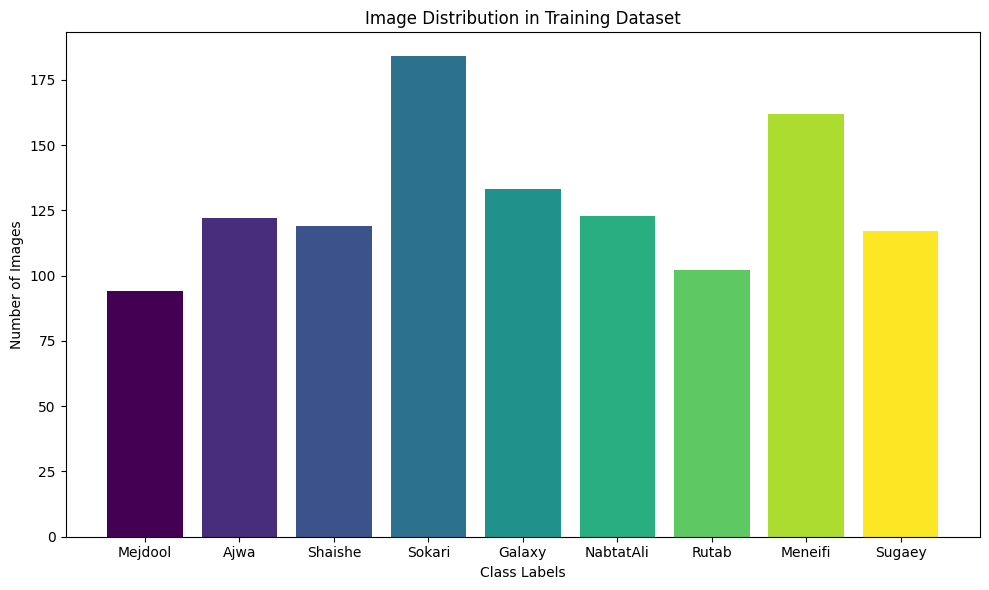

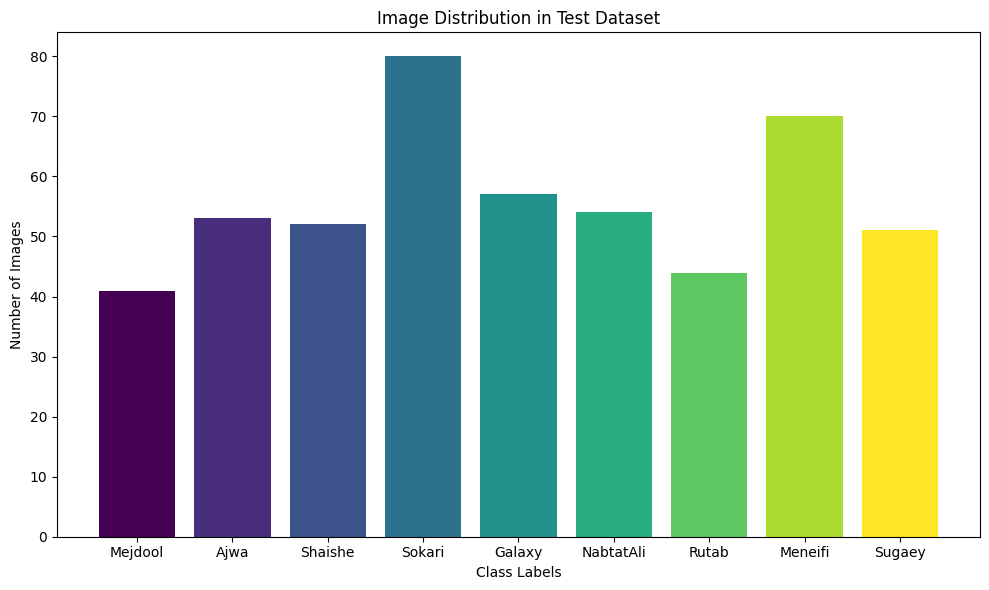

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the image distribution
def plot_image_distribution(class_counts, dataset_type):
    # Generate a list of random colors, one for each class
    num_classes = len(class_counts)
    colors = plt.cm.viridis(np.linspace(0, 1, num_classes))  # Using a colormap

    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color=colors)
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title(f'Image Distribution in {dataset_type} Dataset')
    plt.tight_layout()
    plt.show()

# Plot the distributions for training and test datasets
plot_image_distribution(train_counts, 'Training')
plot_image_distribution(test_counts, 'Test')


# Model training

In [ ]:
import numpy as np
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report

# Set constants
IMAGE_SIZE = (600, 400)
BATCH_SIZE = 16
EPOCHS = 100
NUM_CLASSES = 9

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.10 # 10% for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training' # This uses the training subset
)

# Validation data generator (using the validation split from training data)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation' # This uses the validation subset
)


# Test data generator (no augmentation)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Load the MobileNetV2 model with pre-trained weights
base_model = EfficientNetV2L(weights="imagenet", include_top=False, input_shape=(600, 400, 3))
base_model.trainable = False

for layer in base_model.layers[-80:]: # Unfreeze the last 80 layers
    layer.trainable = True

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x) # Pooling to get a feature vector

# First dense layer with Batch Normalization and Dropout
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Second dense layer with Batch Normalization and Dropout
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Third dense layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)


predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Final output layer for classification

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')

# Compile the model using AdamW optimizer
optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop]
)


2024-11-16 22:24:48.229631: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 22:24:48.239839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731785088.250102    3657 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731785088.252708    3657 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 22:24:48.263648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 1044 images belonging to 9 classes.
Found 112 images belonging to 9 classes.
Found 502 images belonging to 9 classes.


I0000 00:00:1731785089.886560    3657 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
/root/anaconda3/envs/py310-ubuntu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1731785114.813824    3836 service.cc:148] XLA service 0x7f7d18001680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731785114.813860    3836 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-11-16 22:25:15.724508: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731785118.493489    3836 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1731785129.259878    3836 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731785129.698767    3836 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-16 22:25:29.780140: E e

66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 908ms/step - accuracy: 0.3471 - loss: 2.1175 - val_accuracy: 0.7946 - val_loss: 0.8690 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 359ms/step - accuracy: 0.7624 - loss: 0.6802 - val_accuracy: 0.8482 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8366 - loss: 0.5156 - val_accuracy: 0.8929 - val_loss: 0.3206 - learning_rate: 0.0010
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.8770 - loss: 0.3743 - val_accuracy: 0.9375 - val_loss: 0.2190 - learning_rate: 0.0010
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8582 - loss: 0.4131 - val_accuracy: 0.8750 - val_loss: 0.4140 - learning_rate: 0.0010
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 351ms/step - accuracy: 0.8790 - loss: 0.4088 - val_accuracy: 0.9107 - val_loss: 0.2334 - learning_rate: 0.0010
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 376ms/step - accuracy: 0.9074 - loss: 0.2856

# Model Evaluation

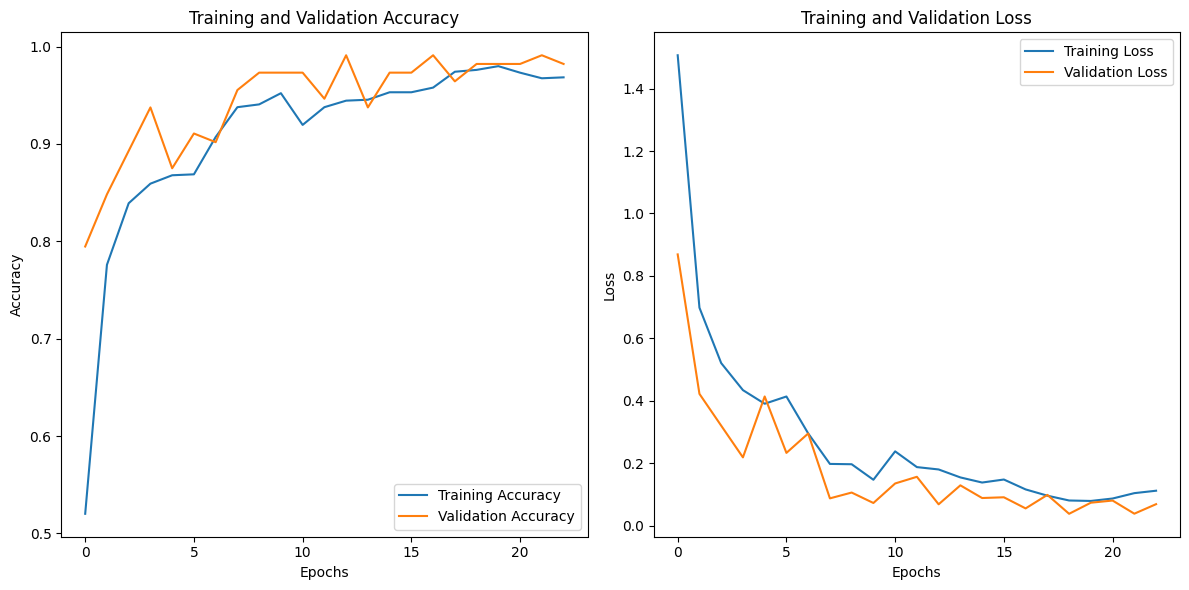

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step
Classification Report:
               precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00        53
      Galaxy       1.00      1.00      1.00        57
     Mejdool       0.97      0.93      0.95        41
     Meneifi       0.97      0.97      0.97        70
   NabtatAli       1.00      1.00      1.00        54
       Rutab       0.96      1.00      0.98        44
     Shaishe       1.00      1.00      1.00        52
      Sokari       1.00      1.00      1.00        80
      Sugaey       0.98      0.98      0.98        51

    accuracy                           0.99       502
   macro avg       0.99      0.99      0.99       502
weighted avg       0.99      0.99      0.99       502



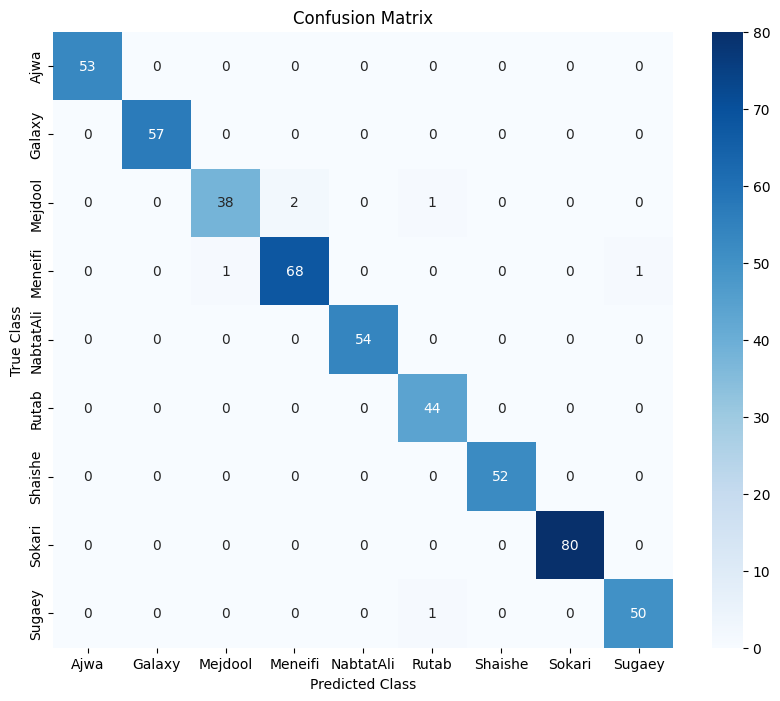

In [6]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate a classification report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Classification Report:\n", classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

# Generate and plot the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm_df = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=cm_df.columns, yticklabels=cm_df.index)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
